SGDRegressor is the most accurate: 96.6 %


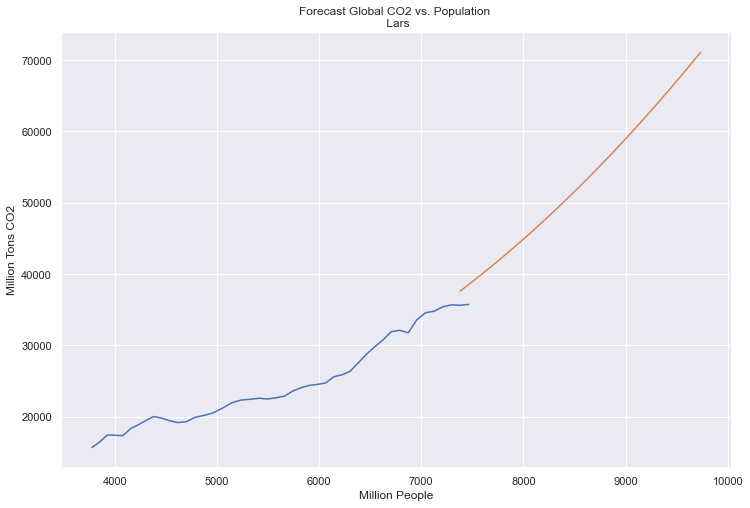

In [1]:
'''Setup'''
import pandas as pd, matplotlib.pyplot as plt, seaborn as sns
sns.set()

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, SGDRegressor, ElasticNet, Lars
from sklearn.metrics import r2_score

'''Data'''
with open(r'data\CO2_vs_population.csv', 'r') as f:
    df = pd.read_csv(f, encoding='utf-8')
    df.columns = ['Year', 'CO2 (tons)', 'Pop', 'MT CO2', 'Million people']

with open(r'data\pop_forecast.csv', 'r') as f:
    forecast_pop = pd.read_csv(f, encoding='utf-8')
    forecast_pop['Total population'] = forecast_pop['Total population'] / 1e6
    forecast_pop = forecast_pop['Total population'].to_numpy()

min_year = df['Year'].min()

x = df[df['Year'] >= min_year]['Million people'].copy().to_numpy().reshape(-1,1)
y = df[df['Year'] >= min_year]['MT CO2'].copy().to_numpy()

'''ML Model'''
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.9, random_state=8)

regression_models = [LinearRegression, Lasso, SGDRegressor, ElasticNet, Lars]
model_performance = {}

for model in regression_models:
    if model is SGDRegressor:
        applied_model = model(max_iter=100000)
    else:
        applied_model = model()

    pipeline = Pipeline(
        [
            ('scalar', StandardScaler()),
            ('poly feature', PolynomialFeatures(2)),
            ('regression', applied_model),
        ])

    pipeline.fit(x_train, y_train)
    model_performance.update({model.__name__: round(100 * pipeline.score(x_test, y_test), 3)})

# identify & implement best model
best_model = max(model_performance)
for i in regression_models:
    if i.__name__ == best_model:
        applied_model = i

if best_model == 'SGDRegressor':
    final_model = applied_model(max_iter=100000)
else:
    final_model = applied_model()


# apply model
pipeline = Pipeline(
    [
        ('scalar', StandardScaler()),
        ('poly feature', PolynomialFeatures(2)),
        ('regression', final_model),
    ])

pipeline.fit(x_train, y_train)
print(f'{best_model} is the most accurate: {round(100 * pipeline.score(x_test, y_test), 1)} %')

# Forecast on last model
pred_co2 = pipeline.predict(forecast_pop.reshape(-1,1))

# Chart
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12, 8))
ax.plot(df[df['Year'] >= min_year]['Million people'], df[df['Year'] >= min_year]['MT CO2'])
ax.plot(forecast_pop, pred_co2)

ax.set_xlabel('Million People')
ax.set_ylabel('Million Tons CO2')
ax.set_title(f'Forecast Global CO2 vs. Population \n {model.__name__}')

plt.show();